In [1]:
import pandas as pd
import random

# Data preprocessing
- Randomly split the data by patient ids into 3 sites

In [2]:
random.seed(233)
df = pd.read_csv('example_data/pheno.csv', index_col=0)
split = [random.randint(1,3) for i in range(400)]
df['site'] = split
df['(intercept)'] = 1
data = [df[df['site']==i+1].reset_index(drop=True)[['(intercept)','age','sex']] for i in range(3)]
out = [df[df['site']==i+1].reset_index(drop=True)['disease'] for i in range(3)]
X_all = df[['age','sex','(intercept)']]
y_all = df['disease']
ans = pd.concat([df[df['site']==i+1] for i in range(3)])
idx = ans.index - 1 
idx_inv = ans.reset_index().sort_values('id').index
kins = pd.read_csv('example_data/GRM.csv')
kins = kins.iloc[idx,idx].reset_index(drop=True).T.reset_index(drop=True) # align with the split datasets

In [3]:
G = pd.read_table('example_data/geno.txt', skiprows=5, header=None, index_col=0)
geno = G.iloc[:,2:].T.reset_index(drop=True).T
ans = geno.T
ans['site'] = split
geno_list = [ans[ans.site==i+1].drop('site', axis=1).reset_index(drop=True).T for i in range(3)]

# FedGMMAT

- Simulated federated training

In [4]:
from fGMMAT import FedGLMMkin

In [5]:
model = FedGLMMkin(data, out, kins)
model.fit()


Iteration 1:

Variance component estimates:
tensor([1.0000, 0.5333], grad_fn=<IndexPutBackward0>)
Fixed-effect coefficients:
tensor([ 0.5573, -0.0072, -0.0850], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

Iteration 2:

Variance component estimates:
tensor([1.0000, 0.4793], grad_fn=<IndexPutBackward0>)
Fixed-effect coefficients:
tensor([ 0.4948, -0.0069, -0.0861], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

Iteration 3:

Variance component estimates:
tensor([1.0000, 0.3217], grad_fn=<IndexPutBackward0>)
Fixed-effect coefficients:
tensor([ 0.4940, -0.0069, -0.0868], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

Iteration 4:

Variance component estimates:
tensor([1.0000, 0.3579], grad_fn=<IndexPutBackward0>)
Fixed-effect coefficients:
tensor([ 0.4688, -0.0068, -0.0863], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

Iteration 5:

Variance component estimates:
tensor([1.0000, 0.3308], grad_fn=<IndexPutBackward0>)
Fixed-effect coefficients:
tensor

- Simulated federated score test

In [6]:
from fGMMAT import FedGLMMscore

In [7]:
df_test = FedGLMMscore(model, geno_list)
df_test

,SCORE,VAR,PVAL
SNP1,2.004181,4.559671,0.347948
SNP2,3.510316,46.332771,0.606060
SNP3,-0.533400,30.602285,0.923185
SNP4,-3.114941,40.512761,0.624567
SNP5,-4.001351,42.275721,0.538287
...,...,...,...
SNP96,2.233687,20.462373,0.621453
SNP97,2.139565,35.673694,0.720178
SNP98,-4.475855,20.348072,0.321083
SNP99,1.150859,11.920554,0.738886


# Result Visualization

- Load results from R package 'GMMAT' 

NOTICE: Please refer to Benchmark.R file to generate the results, this may require install GMMAT package in R. See the repository of GMMAT https://github.com/hanchenphd/GMMAT

In [8]:
df_r = pd.read_table('glmm.score.text.testoutfile.txt')
df_r

,SNP,Allele1,Allele2,N,AF,SCORE,VAR,PVAL
0,SNP1,A,T,393,0.025445,1.985000,4.55635,0.352406
1,SNP2,A,C,400,0.500000,3.510320,46.33280,0.606060
2,SNP3,A,C,400,0.207500,-0.533400,30.60230,0.923185
3,SNP4,A,G,400,0.298750,-3.114940,40.51280,0.624567
4,SNP5,A,G,400,0.593750,-4.001350,42.27570,0.538287
...,...,...,...,...,...,...,...,...
95,SNP96,A,C,400,0.123750,2.233690,20.46240,0.621453
96,SNP97,A,T,400,0.251250,2.139570,35.67370,0.720178
97,SNP98,A,G,400,0.130000,-4.475860,20.34810,0.321083
98,SNP99,A,T,400,0.067500,1.150860,11.92060,0.738886


In [9]:
import seaborn as sns
import numpy as np
from scipy import stats

<AxesSubplot:title={'center':'Scatter plot of P-values in -log scale ("GMMAT")'}, xlabel='FedGMMAT', ylabel='GMMAT'>

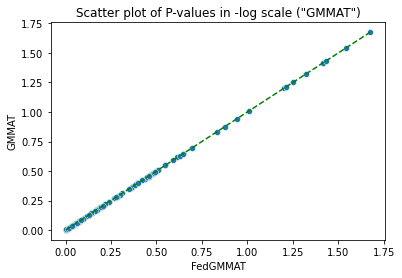

In [10]:
# ax = sns.scatterplot(x=-np.log(Ps.R_projected)/np.log(10), y=-np.log(Ps.fGLMM_projected)/np.log(10))
ax = sns.scatterplot(x=-np.log(df_test.PVAL.values)/np.log(10), 
                     y=-np.log(df_r.PVAL.values)/np.log(10))
ax.set(title='Scatter plot of P-values in -log scale ("GMMAT")', ylabel='GMMAT',
       xlabel='FedGMMAT')
sns.lineplot(x=-np.log(df_test.PVAL.values)/np.log(10), 
             y=-np.log(df_test.PVAL.values)/np.log(10), 
             color='g', linestyle='--')

# Correlation tests

In [11]:
stats.spearmanr(df_test.PVAL.values, df_r.PVAL.values)

SpearmanrResult(correlation=0.9999879987998799, pvalue=3.448065874529609e-228)

In [12]:
stats.pearsonr(df_test.PVAL.values, df_r.PVAL.values)

(0.9999987931965519, 4.527590970858344e-277)